# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.48866 CV = 0.463102
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

Versão 1.0.1: LB = 0.48991 CV = 0.462946
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com novas features)

Versão 1.0.2: LB = 0.48915 CV = 0.464442
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com agrupamento pela coluna v2)

Versão 1.0.3: LB = 0.88299 CV = 0.344659
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado interno

Versão 1.0.4: LB = 0.6041 CV = 0.461724
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (modificado v1)

Versão 1.0.5: LB = 0.48897 CV = 0.466055 (kfold)   CV = 0.466422 (StratifiedKFold)
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado com pacotes estatisticos

Versão 1.0.6: LB = 0.49521 CV = 0.466138 (kfold)
- modelo: LightGBM (com algumas otimizações)
- features engineering: Kernel_Feature_Engineering_v.1.0.0
- utilizado features categoricas no lgb

Versão 1.0.7: LB = ???? CV = 0.466266 (kfold)
- modelo: LightGBM (com algumas otimizações)
- features engineering: Kernel_Feature_Engineering_v.1.0.0
- aplicado scala nos dados numericos
- utilizado features categoricas no lgb

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder


In [3]:
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Carregando os dados de treino e teste

In [4]:
def read_data():
    
    print('Carregando arquivo dataset_treino_new.csv....')
    train = pd.read_csv('../dataset/dataset_treino_new.csv')
    print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))

    print('Carregando arquivo dataset_teste_new.csv....')
    test = pd.read_csv('../dataset/dataset_teste_new.csv')
    print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [5]:
# Leitura dos dados
train, test = read_data()
df = train.append(test)
df = df.drop(columns = ['1'], axis = 1)

Carregando arquivo dataset_treino_new.csv....
dataset_treino.csv tem 114321 linhas and 184 colunas
Carregando arquivo dataset_teste_new.csv....
dataset_teste.csv tem 114393 linhas and 183 colunas


In [6]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"]
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  164
Number of Categorical features:  19


In [7]:
df.head()

,ID,grp_1,grp_10,grp_11,grp_12,grp_2,grp_3,grp_4,grp_5,grp_6,grp_7,grp_8,grp_9,ica_1,ica_10,ica_11,ica_12,ica_2,ica_3,ica_4,ica_5,ica_6,ica_7,ica_8,ica_9,pca_1,pca_10,pca_11,pca_12,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,srp_1,srp_10,srp_11,srp_12,srp_2,srp_3,srp_4,srp_5,srp_6,srp_7,srp_8,srp_9,target,tsvd_1,tsvd_10,tsvd_11,tsvd_12,tsvd_2,tsvd_3,tsvd_4,tsvd_5,tsvd_6,tsvd_7,tsvd_8,tsvd_9,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119 v123,v119 v48,v119 v85,v119^2,v119_x,v119_y,v120,v121,v122,v123 v48,v123 v85,v123^2,v123_x,v123_y,v124,v125,v126,v127,v129,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v26,v27,v28,v29,v3,v30,v31,v35,v36,v37,v39,v4,v40,v42,v44,v45,v47,v48 v85,v48^2,v48_x,v48_y,v5,v50,v51,v52,v56,v57,v58,v59,v6,v61,v62 v119,v62 v123,v62 v48,v62 v85,v62^2,v62_x,v62_y,v66,v68,v69,v7,v70,v71,v72,v74,v75,v78,v79,v80,v81,v82,v84,v85^2,v85_x,v85_y,v86,v88,v9,v90,v91,v92,v93,v94,v98,v99
0,3,-91.710680,27.716370,54.711456,120.17605,49.214336,39.819320,6.008493,0.239730,-2.993159,-28.929620,74.760445,96.09949,-0.003843,-0.001623,0.000137,0.000271,-0.000946,0.002434,-0.001772,-0.000151,0.003242,-0.000800,-0.000453,-0.001254,-48.164520,-0.424896,2.754712,-1.715571,1.603576,-0.998099,-14.700655,-1.278328,8.710470,2.471012,3.199084,-0.098913,-1.847689,-2.408795,-29.066944,22.876034,-31.847212,9.526614,-133.76234,5.287480,17.142406,-20.641521,-0.262313,-36.283512,1.0,153.40079,0.464463,1.347929,2.678761,-62.110138,-3.816818,7.057063,-13.019275,-1.451880,8.745543,2.470521,3.073173,1.335739,0.503281,19.470200,8.389236,2.757375,4.374296,1.574039,0.007294,12.579185,E,2.382692,3.930922,16.434109,B,0.433213,O,NaN,15.634908,2.857144,1.951220,6.592012,5.909091,-1.253049e-06,-0.000008,-1.075170e-06,3.965754e-13,-6.297423e-07,-6.297423e-07,1.059603,0.803572,8.000000,24.219074,3.397185,3.959225,1.989780,1.989780,0.035754,AU,1.804126,3.113719,0,0.636364,2.857144,11.636387,1.355013,8.571428,3.670350,0.106720,0.148883,8.727474,18.869284,7.730923,XDX,-1.716131e-08,C,1.720818,3.393503,0.590122,8.880867,C,C,A,8.375452,11.326591,0.454546,4.012088,3.921026,7.711453,12.707581,10.498338,9.848672,C,20.781006,148.15110,12.171734,12.171734,7.915266,0.899420,7.277793,G,DI,3.971118,0.529802,10.890984,2.599278,15.858151,-6.297423e-07,1.989780,12.171734,1.707317,1.0,1,1.0,C,15.231789,17.142857,3.176895,11.784549,F,1,B,D,8.571429,E,3.000000,7.528326,8.861647,1.299638,2.914931,1.707317,1.707317,0.866426,3.321300,9.999999,0.905342,A,0.442252,5.814018,3.517721,8.877414,1.191337
1,4,-93.247940,38.592617,54.511680,123.92817,48.573597,45.229984,7.246580,-17.264480,0.030932,-14.308875,94.821140,91.57980,-0.000614,0.001376,0.000588,-0.004100,0.000371,-0.003999,-0.000468,-0.000084,-0.000147,0.000706,-0.000207,0.001949,-25.950914,1.779193,-2.487668,-0.286266,5.677019,-0.396850,-0.618112,12.524258,1.614324,-1.088056,-5.308384,1.685836,0.007697,2.013834,-28.929590,57.018020,-27.310768,18.562830,-157.43951,14.462655,9.338835,-19.964195,-7.352732,-38.573727,1.0,171.01410,0.914076,-2.541605,-1.772064,-48.366608,-0.820012,1.806945,0.119447,12.426791,1.585607,-1.087751,-5.426009,1.469550,1.312910,14.475939,6.623713,2.462898,5.125846,2.512034,1.505335,12.085176,B,1.825361,4.247858,15.495952,A,3.108809,U,G,10.308044,10.476191,2.222223,10.595357,8.136964,4.003565e+00,18.140322,3.792658e+00,2.136160e+00,1.461561e+00,1.461561e+00,1.144708,2.436195,6.749117,33.998367,7.108153,7.503433,2.739240,2.739240,0.598896,AF,1.614802,2.963620,0,1.560137,1.589403,11.636386,1.992031,4.932127,3.554267,0.773906,0.198655,7.023803,18.036585,6.763110,GUV,1.845672e-07,C,1.826276,2.673322,5.043831,8.296139,C,C,A,8.068506,14.579479,0.642856,0.378418,4.205991,14.305766,12.934363,10.782008,9.156046,E,32.207340,154.04800,12.411608,12.411608,9.191265,1.379210,7.134018,G,DY,4.067039,5.330551,10.535108,2.412790,15.075894,2.923122e+00,5.478479,24.823215,5.189874,4.0,2,2.0,A,18.274548,9.516129,2.452166,12.053353,F,2,B,D,13.3333

In [8]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] =df[c].astype('category')

In [9]:
scaler = StandardScaler()
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'float64' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [10]:
df.head()

,ID,grp_1,grp_10,grp_11,grp_12,grp_2,grp_3,grp_4,grp_5,grp_6,grp_7,grp_8,grp_9,ica_1,ica_10,ica_11,ica_12,ica_2,ica_3,ica_4,ica_5,ica_6,ica_7,ica_8,ica_9,pca_1,pca_10,pca_11,pca_12,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,srp_1,srp_10,srp_11,srp_12,srp_2,srp_3,srp_4,srp_5,srp_6,srp_7,srp_8,srp_9,target,tsvd_1,tsvd_10,tsvd_11,tsvd_12,tsvd_2,tsvd_3,tsvd_4,tsvd_5,tsvd_6,tsvd_7,tsvd_8,tsvd_9,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119 v123,v119 v48,v119 v85,v119^2,v119_x,v119_y,v120,v121,v122,v123 v48,v123 v85,v123^2,v123_x,v123_y,v124,v125,v126,v127,v129,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v26,v27,v28,v29,v3,v30,v31,v35,v36,v37,v39,v4,v40,v42,v44,v45,v47,v48 v85,v48^2,v48_x,v48_y,v5,v50,v51,v52,v56,v57,v58,v59,v6,v61,v62 v119,v62 v123,v62 v48,v62 v85,v62^2,v62_x,v62_y,v66,v68,v69,v7,v70,v71,v72,v74,v75,v78,v79,v80,v81,v82,v84,v85^2,v85_x,v85_y,v86,v88,v9,v90,v91,v92,v93,v94,v98,v99
0,3,0.284983,-0.534014,0.736863,-0.340864,0.418870,-0.490139,-0.247615,0.599043,-0.549967,-1.083057,-0.550975,0.544216,-1.299425,-0.548702,0.046250,0.091766,-0.319781,0.823156,-0.599172,-0.050928,1.096282,-0.270424,-0.153234,-0.424113,-0.476413,-0.115965,0.840232,-0.598992,0.053336,-0.056296,-1.230837,-0.133529,0.998863,0.421615,0.784215,-0.024982,0.229015,-0.277757,-0.306121,-0.573903,-0.339989,-0.575592,0.503433,-0.057916,3.687203,0.130104,-0.063298,0.058792,1.0,-0.436806,0.112157,0.371820,0.853204,-0.486781,-0.118569,0.366428,-1.144121,-0.147694,1.039342,0.421628,0.753335,-0.273576,-0.988231,1.195798,0.923538,0.041530,-0.913521,-1.508839,-0.409586,0.299978,E,0.439432,0.077249,1.632372,B,-2.504059,O,NaN,0.788031,-5.373542,-0.614543,-0.581994,-1.558740,-0.378212,-0.621254,-0.485865,-0.323319,-0.736194,-0.736476,-0.302955,-1.750176,0.897084,-0.505186,-0.531053,-0.372274,-0.605825,-0.606126,-0.337127,AU,0.413926,-0.005410,0,-1.167999,1.385758,-0.318836,-1.244093,2.714578,-0.025970,-1.459671,-0.513787,0.660138,1.116621,0.655228,XDX,-0.200759,C,-0.317713,1.091411,-2.221761,0.655026,C,C,A,0.275862,-1.226973,-0.601631,1.712322,-0.288161,-0.869035,-0.300062,-0.180545,0.454757,C,-0.769916,-0.245851,-0.191117,-0.190861,-0.510561,-0.519772,0.057062,G,DI,-0.200737,-1.165057,0.214430,0.389800,0.659860,-0.576480,-0.406827,-0.085294,-0.484568,-0.248768,1,-0.044084,C,-1.489107,5.373229,1.593361,-0.329633,F,1,B,D,-3.443810,E,1.043807,0.083335,1.215143,-0.320865,-0.712988,-0.948463,-0.951520,-0.924251,1.855822,0.658485,-0.421476,A,-0.618167,0.338959,-0.446345,0.692061,-0.150137
1,4,0.247289,-0.215583,0.725725,-0.233193,0.361223,-0.070318,-0.100797,0.177208,-0.111968,0.481819,-0.133596,0.165277,-0.207496,0.465178,0.198894,-1.386433,0.125599,-1.352380,-0.158421,-0.028256,-0.049809,0.238766,-0.070124,0.658993,-0.256690,0.485589,-0.758779,-0.099950,0.188821,-0.022384,-0.051752,1.308231,0.185121,-0.185649,-1.301283,0.425793,0.295814,0.801267,-0.302938,-0.004329,-0.237710,-0.114924,0.223371,0.256734,0.118357,0.288222,-0.218627,-0.375403,1.0,-0.194988,0.227488,-0.738169,-0.543243,-0.302899,0.039059,-0.009019,-0.028306,1.302570,0.206482,-0.185501,-1.338892,-0.109098,-0.408044,0.255077,-0.074672,-0.172760,-0.106319,-0.111877,0.444024,0.077545,B,-0.361128,0.187727,0.048226,A,-0.129457,U,G,-1.248812,-0.029189,-0.077012,0.874717,-0.085816,-0.264805,-0.285855,-0.280839,-0.281633,-0.290284,-0.290535,-0.150887,-0.167660,-0.031415,-0.230889,-0.246651,-0.242537,-0.228143,-0.228421,0.003198,AF,-0.085424,-0.127759,0,-0.215013,-0.096439,-0.318837,-0.091241,0.006115,-0.106431,-0.085034,-0.109636,-0.104224,0.169136,-0.255001,GUV,-0.200759,C,-0.065195,-0.060804,-0.016159,0.050705,C,C,A,-0.028945,0.583161,-0.136024,-0.266091,0.041857,1.211011,0.002589,-0.001430,0.007558,E,-0.153034,-0.107554,-0.045682,-0.045428,0.312745,-0.108551,-0.019587,G,DY,-0.012061,-0.254650,-0.014056,-0.028443,0.174291,0.081449,0.654882,1.336596,1.044028,1.117180,2,1.393197,A,0.231228,0.026695,-0.038507,-0.177191,F,2,B,D,-0.

# Algoritmo LigthGBM

In [11]:
# Configurações Gerais

GENERATE_SUBMISSION_FILES = True
SUBMISSION_SUFIX = "_lgbm_v.1.0.7"
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 1000

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',#'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [12]:
# ------------------------- LIGHTGBM MODEL -------------------------

def run_model(data, categorical_feature = None):
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    del_features = ['target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        
        if not categorical_feature.empty:
            clf.fit(train_x, train_y, 
                    eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', 
                    verbose=400, 
                    early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, 
                    eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', 
                    verbose=400, 
                    early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), 
                    categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds))
    test['target'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)

        
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Generate oof csv
        oof = pd.DataFrame()
        oof['ID'] = df['ID'].copy()
        df['predictions'] = oof_preds.copy()
        df['target'] = df['target'].copy()
        df.to_csv('oof{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        # Save submission (test data) and feature importance
        test[['ID', 'target']].to_csv('../submission/submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        plt.hist(test['target'])
        plt.show()        
        
    return mean_importance

Train/valid shape: (114321, 183), test shape: (114393, 183)
Training until validation scores don't improve for 1000 rounds
[400]	training's binary_logloss: 0.463756	valid_1's binary_logloss: 0.47502
[800]	training's binary_logloss: 0.443973	valid_1's binary_logloss: 0.467331
[1200]	training's binary_logloss: 0.431348	valid_1's binary_logloss: 0.4652
[1600]	training's binary_logloss: 0.420351	valid_1's binary_logloss: 0.463907
[2000]	training's binary_logloss: 0.410778	valid_1's binary_logloss: 0.462923
[2400]	training's binary_logloss: 0.401593	valid_1's binary_logloss: 0.462169
[2800]	training's binary_logloss: 0.392872	valid_1's binary_logloss: 0.461311
[3200]	training's binary_logloss: 0.384742	valid_1's binary_logloss: 0.460564
[3600]	training's binary_logloss: 0.376882	valid_1's binary_logloss: 0.460274
[4000]	training's binary_logloss: 0.369546	valid_1's binary_logloss: 0.46
[4400]	training's binary_logloss: 0.362511	valid_1's binary_logloss: 0.459695
[4800]	training's binary_log

[6000]	training's binary_logloss: 0.337105	valid_1's binary_logloss: 0.462013
Early stopping, best iteration is:
[5195]	training's binary_logloss: 0.349351	valid_1's binary_logloss: 0.461624
Fold  6 Log Loss : 0.461624
Training until validation scores don't improve for 1000 rounds
[400]	training's binary_logloss: 0.463521	valid_1's binary_logloss: 0.476141
[800]	training's binary_logloss: 0.443447	valid_1's binary_logloss: 0.470047
[1200]	training's binary_logloss: 0.430784	valid_1's binary_logloss: 0.468272
[1600]	training's binary_logloss: 0.419733	valid_1's binary_logloss: 0.467542
[2000]	training's binary_logloss: 0.410079	valid_1's binary_logloss: 0.467076
[2400]	training's binary_logloss: 0.40087	valid_1's binary_logloss: 0.466526
[2800]	training's binary_logloss: 0.392189	valid_1's binary_logloss: 0.466219
[3200]	training's binary_logloss: 0.383942	valid_1's binary_logloss: 0.465932
[3600]	training's binary_logloss: 0.376103	valid_1's binary_logloss: 0.46549
[4000]	training's bi

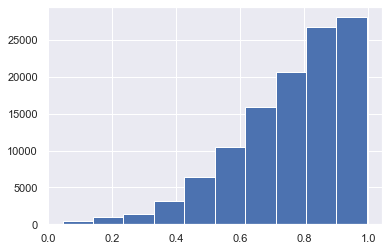

In [13]:
mean_importance = run_model(df, categorical_feats)